In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from datetime import timedelta
from sklearn.metrics import mean_squared_error

# NeuralProphet
!pip install neuralprophet[live] --quiet

from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed

set_random_seed(0)

## Neural Prophet (Meta AI)

In this article, I will use NeuralProphet to forecast energy demand. Forecasting energy demand is extremely important as the demand for electricity increases. Knowing how much electricity is needed ahead of time has a significant impact on carbon emissions, energy cost, and policy decisions<sup>1</sup>.

On November 30, 2021, Meta AI (formerly Facebook) released NeuralProphet. NeuralProphet was built to bridge the gap between classical forecasting techniques and deep learning models. In this article, I will showcase the NeuralProphet framework and evaluate its performance against other forecasting techniques.

#### Useful Resources

* [NeuralProphet Documentation](https://neuralprophet.com/html/full_simple_model.html)
* [NeuralProphet Release Blog Post](https://ai.facebook.com/blog/neuralprophet-the-neural-evolution-of-facebooks-prophet/)
* [Is Facebook's "Prophet" the Time-Series Messiah, or Just a Very Naughty Boy?](https://www.microprediction.com/blog/prophet)


## Loading Data

The dataset we are going to use contains electricity demand data from Victoria, Australia. Victoria is home to 6.7 million people. The dataset has daily data points from January 1st, 2015 to October 6th, 2020. This gives us enough samples to pick up on any seasonality and trends in the dataset.

---

In the following cell, we load this dataset into pandas for preprocessing. Similar to Prophet, NeuralProphet requires a 'ds' column for the date/time stamp, and a 'y' column for the data value.

In [2]:
fpath = "../input/electricity-demand-in-victoria-australia/complete_dataset.csv"

df = pd.read_csv(fpath)
demand_df = df[['date','demand']].rename(columns={"date": "ds", "demand": "y"})
demand_df['ds'] = pd.to_datetime(demand_df['ds'])
demand_df.head()

,ds,y
0,2015-01-01,99635.030
1,2015-01-02,129606.010
2,2015-01-03,142300.540
3,2015-01-04,104330.715
4,2015-01-05,118132.200


We can then use Matplotlib to visualize the data. In the first plot we can see all of the datapoints. It appears that there is some yearly seasonality in the data. The energy demand generally increases every year until June, where it then decreases for the rest of the year.

The second plot simply shows the first 100 days of data. We can see that energy demand is not consistent day to day. If there is any weekly seasonality in the data, it is difficult to identify from this plot.

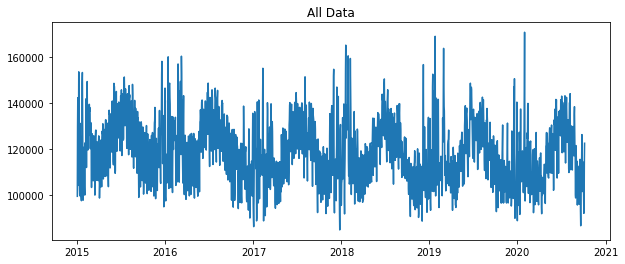

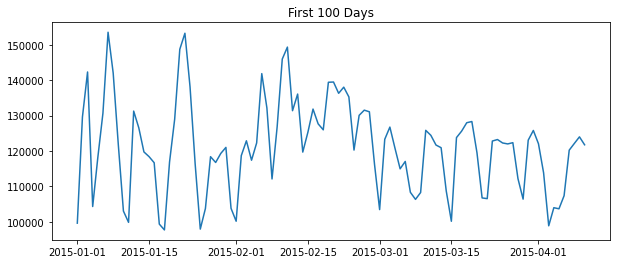

In [3]:
plt.figure(figsize=(10, 4))
plt.title("All Data")
plt.plot(demand_df['ds'].dt.to_pydatetime(), demand_df['y'])
plt.show()

plt.figure(figsize=(10, 4))
plt.title("First 100 Days")
plt.plot(demand_df['ds'].dt.to_pydatetime()[:100], demand_df['y'][:100])
plt.show()

In the next cell, we are simply creating a validation and testing set for the model. We could use the built-in .split_df() function, but I found that this duplicated rows in each set. For this reason, we will use simple indexing.

Note that the validation and testing set should always contain the most recent data points. This ensures that we do not train on data from the future and make predictions on the past.

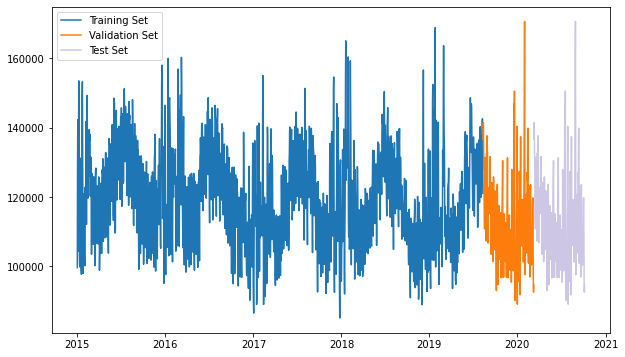

In [4]:
train_size = 0.8

m = NeuralProphet()
df_train, df_valid = demand_df[:int(len(demand_df)*0.8)], demand_df[int(len(demand_df)*0.8):]
df_valid, df_test = df_valid[:len(df_valid)//2], df_valid[len(df_valid)//2:]

def train_valid_plot():
    """Visualizing the training + validation sets"""
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.plot(df_train['ds'].dt.to_pydatetime(), df_train["y"], color='#1f76b4', label='Training Set')
    ax.plot(df_valid['ds'].dt.to_pydatetime(), df_valid["y"], color='#fc7d0b', label='Validation Set')
    ax.plot(df_test['ds'].dt.to_pydatetime(), df_valid["y"], color='#CDC7E5', label='Test Set')
    ax.legend()
    plt.show()
    
train_valid_plot()

## Defining a Model

NeuralProphet uses a very similar API to Prophet. If you have used Prophet before, then using NeuralProphet will be very intuitive.

In the following cell, we are simply defining a model and fitting this model to the data. We use 'D' to set the frequency of predictions as daily, and we use plot-all to visualize model performance live during training. The only other alteration we make is to specify Australian holidays.

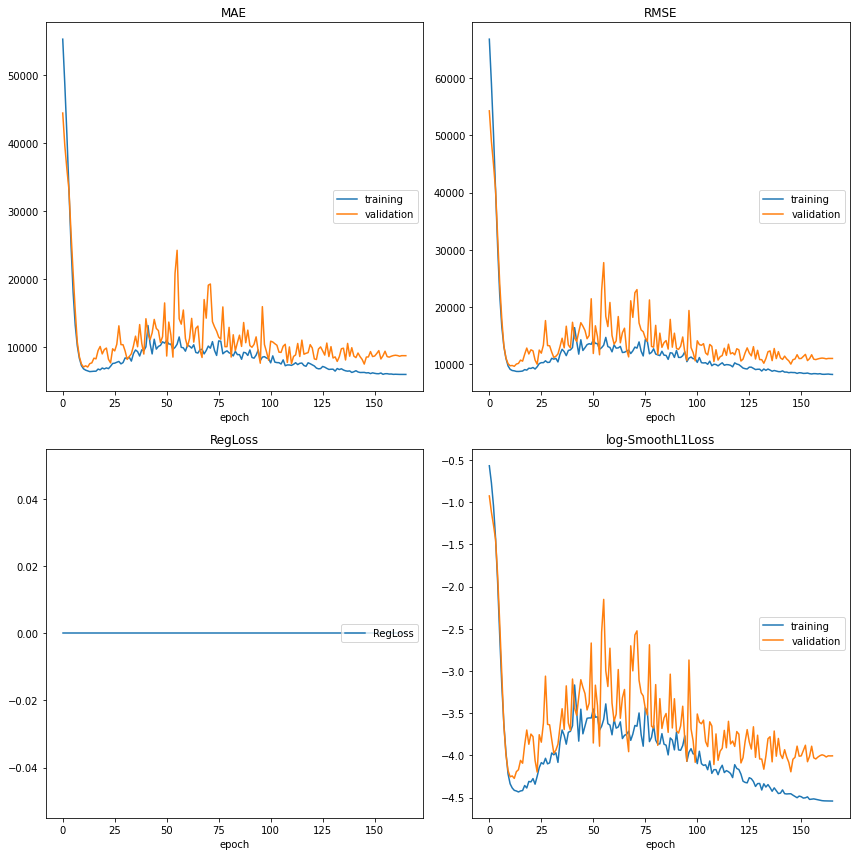

MAE
	training         	 (min: 5932.052, max: 55354.412, cur: 5932.052)
	validation       	 (min: 7022.706, max: 44464.730, cur: 8695.734)
RMSE
	training         	 (min: 8184.474, max: 66821.673, cur: 8184.474)
	validation       	 (min: 9608.028, max: 54284.945, cur: 10979.633)
RegLoss
	RegLoss          	 (min:    0.000, max:    0.000, cur:    0.000)
log-SmoothL1Loss
	training         	 (min:   -4.541, max:   -0.569, cur:   -4.541)
	validation       	 (min:   -4.273, max:   -0.927, cur:   -4.006)


,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
165,0.010664,5932.051561,8184.473519,0.0,0.018212,8695.734375,10979.632812


In [5]:
m = NeuralProphet()

m.add_country_holidays(country_name='Australia')
metrics = m.fit(df=df_train, validation_df=df_valid, freq="D", progress="plot-all")
metrics[-1:]

We can see from the graph above that the model is being overfit to the data. The model is fitting as low as it can on the training data, but we want the model to fit well on unseen data (ie. validation set). 

Looking at the metric plots above, we can see that the optimal parameters are reached around 25–30 epochs and then the model starts to overfit. We can combat this by specifying a number of epochs. A complete list of tuneable model parameters can be found [here](https://neuralprophet.com/html/forecaster.html).

In [6]:
m = NeuralProphet(epochs=30)
m.add_country_holidays(country_name='Australia')
metrics2 = m.fit(df=df_train, validation_df=df_valid, freq="D")
metrics2[-1:]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.941% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32


  0%|          | 0/131 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.05E-01, min: 1.35E+00


  0%|          | 0/131 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.05E-01, min: 1.35E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.04E-01
Epoch[30/30]: 100%|██████████| 30/30 [00:03<00:00,  8.91it/s, SmoothL1Loss=0.0107, MAE=5.94e+3, RMSE=8.26e+3, RegLoss=0, MAE_val=8.46e+3, RMSE_val=1.08e+4, SmoothL1Loss_val=0.0175]


,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
29,0.010706,5944.797654,8260.18913,0.0,0.017509,8459.55957,10765.797852


By specifying the number of epochs, we can significantly reduce the validation RMSE. Even changing one parameter can improve our model significantly (as shown above). This suggests that using parameter tuning, and translating domain knowledge to the model can improve its performance.

## Evaluating a Model

Before we try and squeeze every ounce of performance out of our model, lets see how we can evaluate our model.

In the next cell, we are simply making a forecast that is the same length as the validation set. We can then visualize this using the .plot() function. This gives a decent visualization of the forecast, but does not provide a performance metric, nor can we see the predictions very clearly.

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.941% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.947% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.947% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


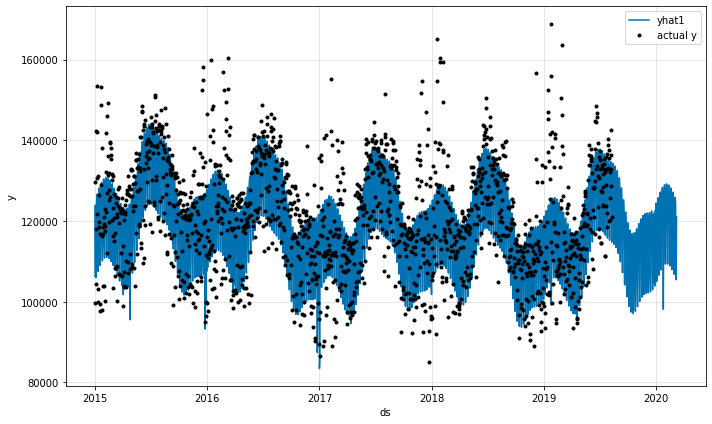

In [7]:
future = m.make_future_dataframe(df=df_train, periods=len(df_valid), n_historic_predictions=True)
forecast = m.predict(df=future)
fig_forecast = m.plot(forecast)

To address the limitations of the built-in plot, I put together a customized plot using Matplotlib. The following cell plots the predictions with the true labels and shows the model metrics in the plot title. 

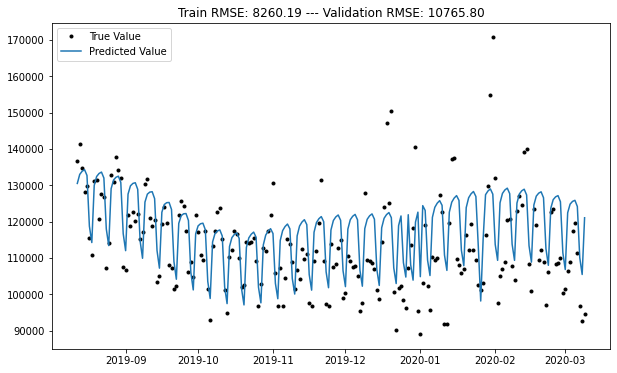

In [8]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_title("Train RMSE: {:.2f} --- Validation RMSE: {:.2f}".format(metrics2[-1:].RMSE.values[0], metrics2[-1:].RMSE_val.values[0]))
ax.plot(df_valid['ds'].dt.to_pydatetime(), df_valid["y"],'.k', label='True Value')
ax.plot(forecast[-len(df_valid):]['ds'].dt.to_pydatetime(), forecast[-len(df_valid):]["yhat1"], label='Predicted Value')
ax.legend()
plt.show()

Next, we can look at the model parameters. This can give us a sense of seasonality patterns and the trend of the data. 

In the first and second plots, we can see that there was a spike in energy demand in 2018. Then, the demand dips and steadily increases throughout 2019 and 2020. This gives us a sense of how energy demand changes over time.

In the third plot, we are looking at the yearly seasonality. We can see that energy demand is at its lowest in April and October, and energy demand is at its highest in July. This makes sense, as July is the coldest month of the year in Australia. Interestingly, the warmest month is February, when we see a small spike in energy demand. This could indicate that people use electricity for Air Conditioning during the hottest month.

The fourth plot shows the weekly seasonality. This indicates that the energy consumption is at its lowest on Saturday and Sunday.

Finally, we have the plot of the additive events. This plot shows the effect of the Australian holidays that we added. We can see that on Holidays, the energy demand is typically lower than usual.

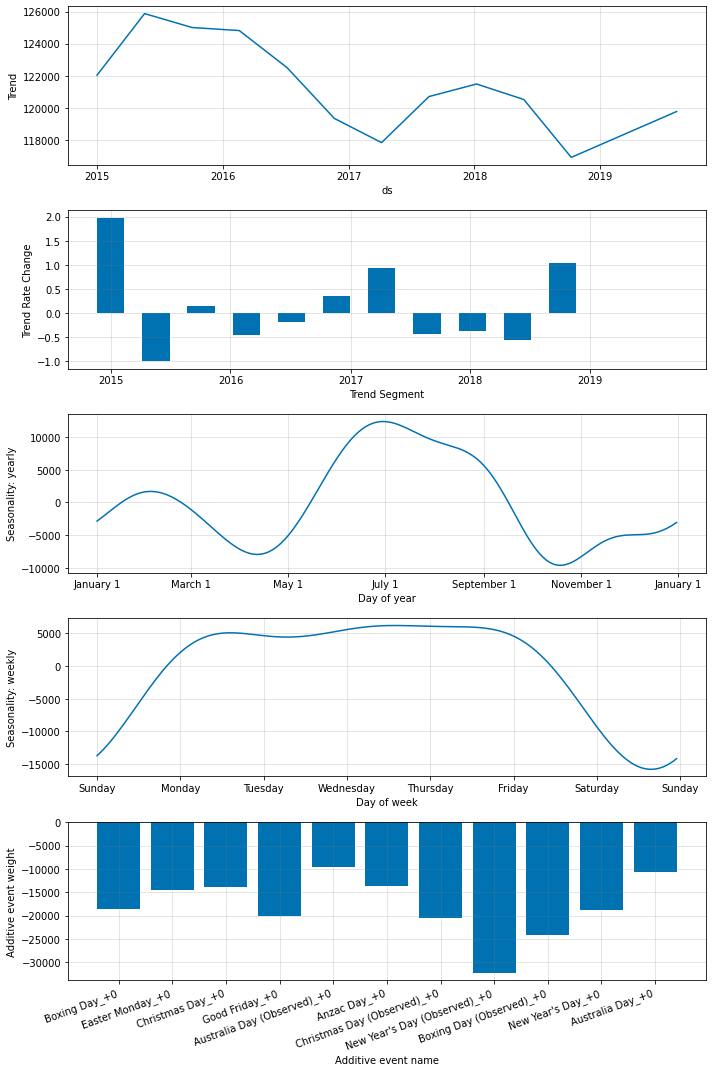

In [9]:
# fig_comp = m.plot_components(forecast) # Alternative: shows a slightly different figure
fig_param = m.plot_parameters()

## Adding AR-Net (AutoRegression)

One of the new additions in Prophet is AR-Net (Auto-Regressive Neural Network). This allows NeuralProphet to use observations from previous time steps when making a prediction. In our case, this means that the model can use the previous day's energy demands to make its predictions.

AR-Net can be enabled by setting an appropriate value to the n_lags parameter when creating the NeuralProphet Model. We are also increasing the checkpoints_range as we are making short-term predictions on the data.

In [10]:
m = NeuralProphet(n_forecasts=1, n_lags=3, epochs=30, changepoints_range=0.95)
m.add_country_holidays(country_name='Australia')
metrics3 = m.fit(df=df_train, validation_df=df_valid, freq="D")
metrics3[-1:]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.941% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32


  0%|          | 0/131 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.70E-01, min: 3.00E+00


  0%|          | 0/131 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.70E-01, min: 7.14E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.43E-01
Epoch[30/30]: 100%|██████████| 30/30 [00:03<00:00,  8.25it/s, SmoothL1Loss=0.00616, MAE=4.47e+3, RMSE=6.26e+3, RegLoss=0, MAE_val=6.12e+3, RMSE_val=8.63e+3, SmoothL1Loss_val=0.0112]


,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
29,0.006158,4466.269533,6257.103069,0.0,0.01125,6119.624023,8629.52832


We can see from the metrics above that the validation RMSE decreased again. This is another significant gain in model performance we got by simply tuning two parameters.

If we use the same code that we did previously, only one prediction is made. It is unclear from the docs how to make "running" predictions when AR-Net is enabled, and therefore we can use the following code to make this possible. If anyone knows a built-in way to do this please let me know!

In [11]:
valid_preds = [] #list to store predictions
lags = 3

for d in df_valid['ds'].values:
    # getting necessary df rows
    date_index = demand_df.index[demand_df['ds'] == d][0]
    future = demand_df.iloc[date_index-lags:date_index]
    
    # adding new row
    entry = pd.DataFrame({
        'ds': [d],
        'y' : [np.nan]
    })
    future = pd.concat([future, entry], ignore_index = True, axis = 0)
    
    # making prediction
    forecast = m.predict(df=future)
    valid_preds.append(forecast.loc[lags]['yhat1'])

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data

We can then use the following code block to plot our predictions. We can see from the plot that the model is starting to pick up on outlying points.

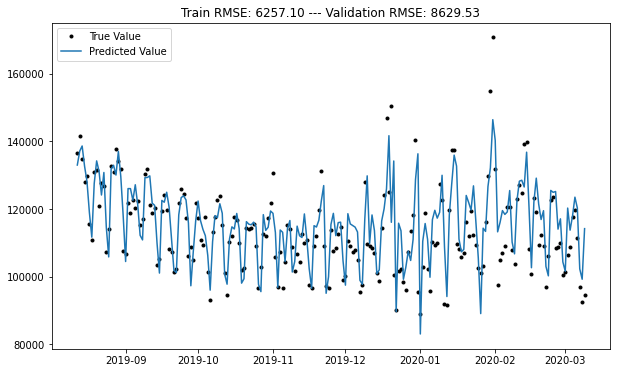

In [12]:
# Creating DF for predictions
df_valid_copy = df_valid.copy()
df_valid_copy['yhat1'] = valid_preds
df_valid_copy.head()

# Plotting Predictions
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_title("Train RMSE: {:.2f} --- Validation RMSE: {:.2f}".format(metrics3[-1:].RMSE.values[0], metrics3[-1:].RMSE_val.values[0]))
ax.plot(df_valid_copy['ds'].dt.to_pydatetime(), df_valid_copy["y"],'.k', label='True Value')
ax.plot(df_valid_copy['ds'].dt.to_pydatetime(), df_valid_copy["yhat1"], label='Predicted Value')
ax.legend()
plt.show()

If we then plot the model components, we can see that there is an additional plot shown. This plot shows how much each lagged term affects the prediction. In our case, we can see that the most recent days are the most important to the model. In most time series problems, this is often the case.

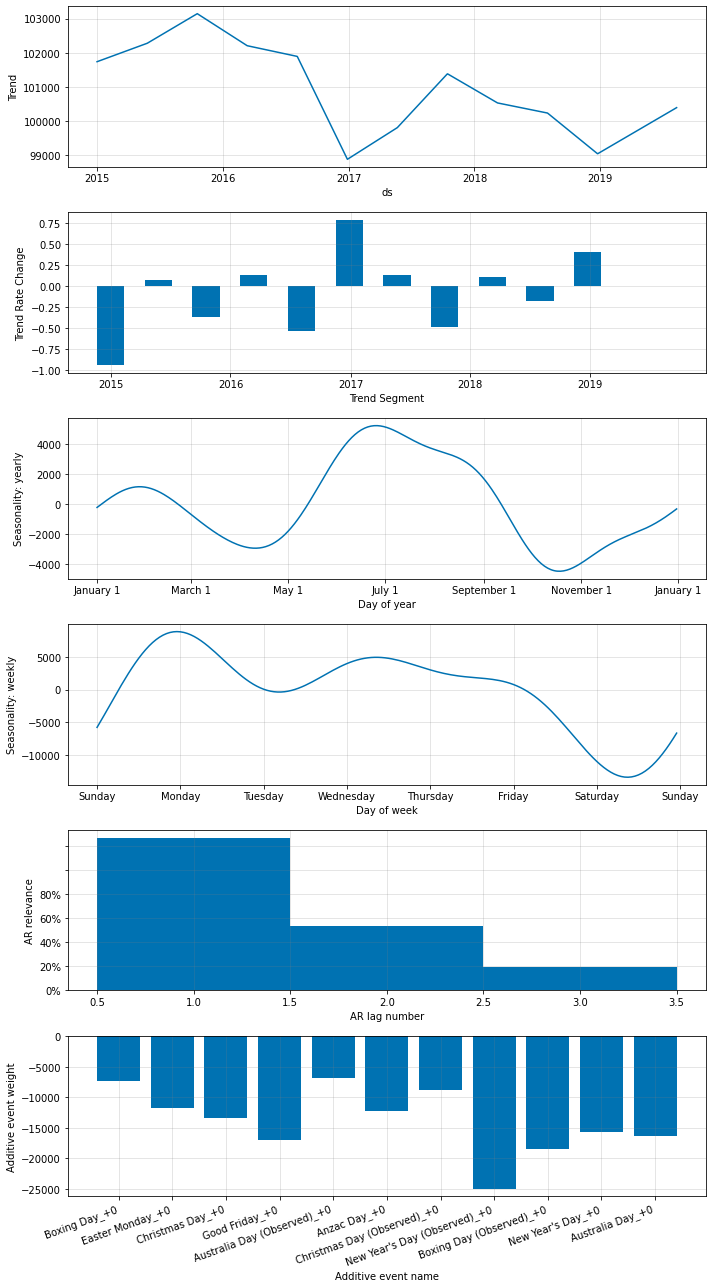

In [13]:
fig_param = m.plot_parameters()

## Hyperparameter tuning

Up to this point, we have been able to improve our validation RMSE manually. This is pretty good, but we only tuned a couple of parameters. What about other parameters? Consider the following list of tuneable parameters and their default values.

> *NeuralProphet(growth='linear', changepoints=None, n_changepoints=10, changepoints_range=0.9, trend_reg=0, trend_reg_threshold=False, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', seasonality_mode='additive', seasonality_reg=0, n_forecasts=1, n_lags=0, num_hidden_layers=0, d_hidden=None, ar_reg=None, learning_rate=None, epochs=None, batch_size=None, loss_func='Huber', optimizer='AdamW', newer_samples_weight=2, newer_samples_start=0.0, impute_missing=True, collect_metrics=True, normalize='auto', global_normalization=False, global_time_normalization=True, unknown_data_normalization=False)*

It would take a lot of time and effort to manually enter all the possible combinations of these parameters. We can combat this by implementing hyperparameter tuning. In this implementation, we are simply testing all possible combinations of parameters in the parameter grid. This means that the number of possible combinations grows exponentially as more parameters are added<sup>2</sup>.

This could potentially be improved using bayesian optimization to more efficiently search the parameter space, but adding this functionality is out of the scope of this notebook. In the following cell, we are creating a parameter grid and then training models using all the possible parameter combinations.

In [14]:
# Parameter Options
param_grid = {  
    'num_hidden_layers': [1,2],
    'changepoints_range': [0.95, 0.975, 0.99, 0.995, 0.999],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
results = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = NeuralProphet(**params, n_forecasts=1, newer_samples_weight=4, n_lags=3, learning_rate=0.02, epochs=50, batch_size=32)
    m.add_country_holidays(country_name='Australia')
    metrics4 = m.fit(df=df_train, validation_df=df_valid, freq="D")
    results.append(dict({"RMSE_val": metrics4['RMSE_val'].min(), "RMSE_train": metrics4['RMSE'][metrics4['RMSE_val'].idxmin()], "score_epoch_number": metrics4['RMSE_val'].idxmin()}, **params))

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.941% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
Epoch[50/50]: 100%|██████████| 50/50 [00:06<00:00,  7.53it/s, SmoothL1Loss=0.00614, MAE=4.47e+3, RMSE=6.24e+3, RegLoss=0, MAE_val=5.75e+3, RMSE_val=8.37e+3, SmoothL1Loss_val=0.0106]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.941% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralPr

Next, we are creating a Pandas dataframe to store the lowest RMSE value from each model training cycle. We can then sort by the validation RMSE value, to get a sense of which parameter combinations worked well. The training RMSE score and epoch where when the validation score was at its lowest are also stored.

This is done to ensure that the model is not overfitting to the validation set.

In [15]:
# Find the best parameters
results_df = pd.DataFrame.from_dict(results, orient='columns')
results_df = results_df.sort_values('RMSE_val')
results_df.head(10)

,RMSE_val,RMSE_train,score_epoch_number,num_hidden_layers,changepoints_range
3,8065.256348,6413.459807,38,1,0.995
4,8097.545410,7204.294891,18,1,0.999
2,8205.837891,6524.529333,35,1,0.990
5,8222.151367,6325.075713,43,2,0.950
1,8250.486328,6704.890101,28,1,0.975
6,8268.982422,6333.949760,44,2,0.975
0,8291.004883,6658.028273,17,1,0.950
9,8326.502930,6824.452711,32,2,0.999
8,8404.003906,6711.165158,29,2,0.995
7,9290.185547,8687.061896,30,2,0.990


Looking at the results above, we can see that the first and second rows appear to be overfitting the validation set. On the other hand, the third row shows a similar RMSE score on both the training and validation sets.

In the following cell we are re-entering high scoring model parameters that worked well. We can enable the progress plot to see more information on the model training, and we can make any further changes manually if needed.

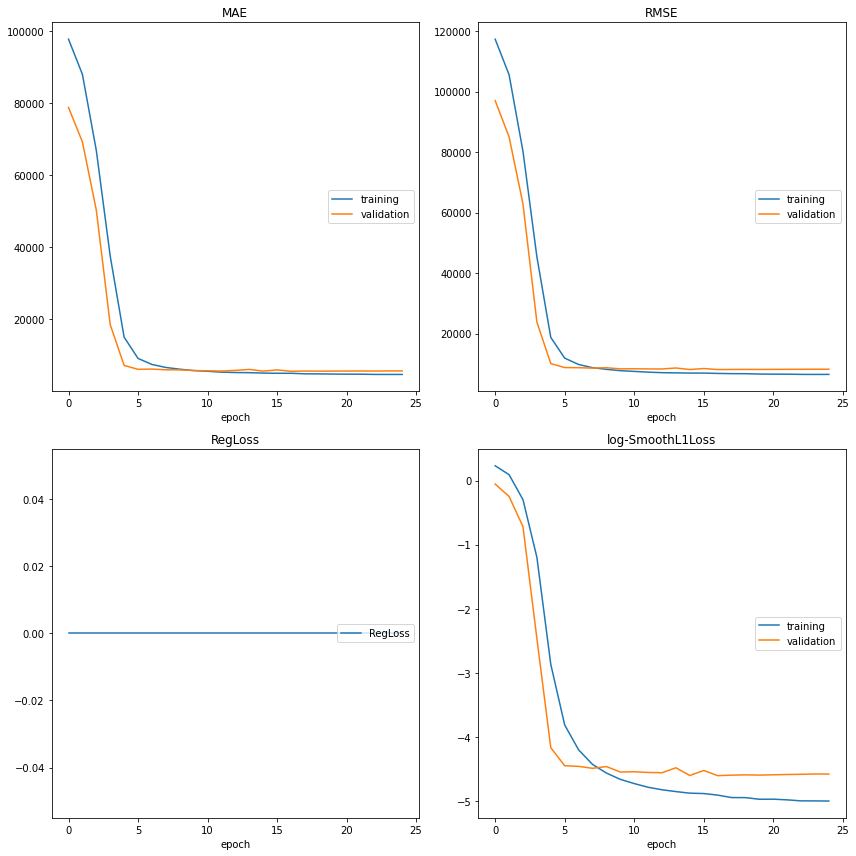

MAE
	training         	 (min: 4720.166, max: 97669.668, cur: 4720.166)
	validation       	 (min: 5597.984, max: 78738.164, cur: 5683.729)
RMSE
	training         	 (min: 6509.915, max: 117330.951, cur: 6523.984)
	validation       	 (min: 8122.580, max: 97000.000, cur: 8225.203)
RegLoss
	RegLoss          	 (min:    0.000, max:    0.000, cur:    0.000)
log-SmoothL1Loss
	training         	 (min:   -5.005, max:    0.233, cur:   -5.005)
	validation       	 (min:   -4.608, max:   -0.053, cur:   -4.583)


,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
24,0.006706,4720.166456,6523.984354,0.0,0.01022,5683.728516,8225.203125


In [16]:
m = NeuralProphet(newer_samples_weight=5, n_forecasts=1, n_lags=3, learning_rate=0.02, epochs=25, batch_size=32, num_hidden_layers=1, changepoints_range=0.995)
m.add_country_holidays(country_name='Australia')
metrics5 = m.fit(df=df_train, validation_df=df_valid, freq="D", progress="plot-all")
metrics5[-1:]

We have reduced the RMSE even more! As we improve the model performance it becomes more and more difficult to make improvements. That being said we are looking for progress not perfection and will take improvements where we can.

The forecast can then be plotted in the same way as we did earlier in the notebook.

In [17]:
valid_preds = [] #list to store predictions
lags = 3

for d in df_valid['ds'].values:
    # getting necessary df rows
    date_index = demand_df.index[demand_df['ds'] == d][0]
    future = demand_df.iloc[date_index-lags:date_index]
    
    # adding new row
    entry = pd.DataFrame({
        'ds': [d],
        'y' : [np.nan]
    })
    future = pd.concat([future, entry], ignore_index = True, axis = 0)
    
    # making prediction
    forecast = m.predict(df=future)
    valid_preds.append(forecast.loc[lags]['yhat1'])

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data

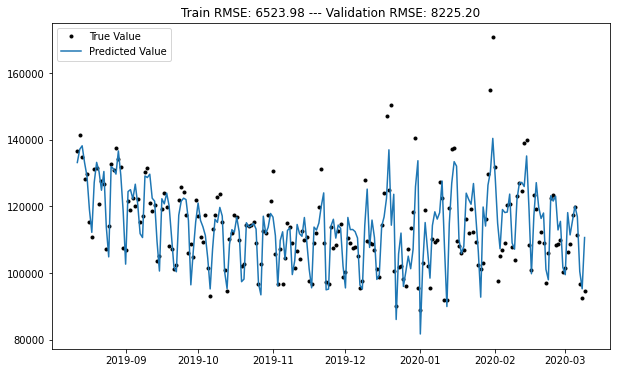

In [18]:
# Creating DF for predictions
df_valid_copy = df_valid.copy()
df_valid_copy['yhat1'] = valid_preds
df_valid_copy.head()

# Plotting Predictions
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_title("Train RMSE: {:.2f} --- Validation RMSE: {:.2f}".format(metrics5[-1:].RMSE.values[0], metrics5[-1:].RMSE_val.values[0]))
ax.plot(df_valid_copy['ds'].dt.to_pydatetime(), df_valid_copy["y"],'.k', label='True Value')
ax.plot(df_valid_copy['ds'].dt.to_pydatetime(), df_valid_copy["yhat1"], label='Predicted Value')
ax.legend()
plt.show()

## Model Performance Comparison

In the next cell, I am going to compare the NeuralProphet model with other common forecasting strategies.

- Predict Last Value
- Exponential Smoothing
- SARIMA
- Neural Prophet

We can manually calculate the RMSE value for each model using sklearn. We can simply pass the parameter `squared=False` to get RMSE from the mean_squared_error function.

Firstly, we can calculate the RMSE if we just predicted the energy demand from the day before. 

In [19]:
# Last Value Method
last_val_df = demand_df.copy()

last_val_df['y_prev'] = last_val_df['y'].shift(1)
last_val_df = last_val_df[last_val_df['ds'].isin(df_test['ds'].values)]
last_val_preds = last_val_df['y'].values

last_val_rmse = mean_squared_error(last_val_preds, last_val_df['y_prev'], squared=False)
last_val_rmse

9217.333842288554

Next, we can calculate a forecasting model using exponential smoothing. This model type uses the weighted averages of past observations, with weights decaying exponentially as observations get older.

In [20]:
# Exponential Smoothing Method
from statsmodels.tsa.api import SimpleExpSmoothing

exp_smooth_preds = []

for d in df_test['ds'].values:
    # Setting up Dataframe
    date_index = demand_df.index[demand_df['ds'] == d][0]
    future = demand_df.iloc[date_index-len(df_train):date_index]
    future = future.set_index('ds')
    future.index = pd.DatetimeIndex(future.index.values, freq='D')
    
    # Make Predictions
    fit = SimpleExpSmoothing(future, initialization_method="heuristic").fit(
            smoothing_level=0.2, optimized=False
        )
    
    exp_smooth_preds.append(fit.forecast(1).values[0])
    
exp_smooth_rmse = mean_squared_error(df_test['y'], exp_smooth_preds, squared=False)
exp_smooth_rmse

9403.163617258026

Next, we can fit a SARIMA model to the data. This model acronym stands for "Seasonal Auto-Regressive Integrated Moving Average", and calculates its forecast exactly how it is named. For information on this model type, check out this great article [here](https://medium.com/@BrendanArtley/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6).

This model is a little more complex, and we will break the training into code blocks. Firstly, the optimal model parameters are found using autoarima. This is essentially a hyper-parameter tuning package for ARIMA models.

In [21]:
!pip install pmdarima --quiet
import pmdarima as pm

# Seasonal - Find best parameters with Auto-ARIMA
SARIMA_model = pm.auto_arima(df_train["y"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=7, #weekly frequency
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

SARIMA_model

ARIMA(order=(1, 0, 1), scoring_args={}, seasonal_order=(0, 1, 1, 7),
      suppress_warnings=True)

Next, we manually create an ARIMA model at each step with the optimal model parameters found above.

In [22]:
%%time
# SARIMA Method
from statsmodels.tsa.arima.model import ARIMA

sarima_preds = []

for d in df_test['ds'].values:
    # Setting up dataframe
    date_index = demand_df.index[demand_df['ds'] == d][0]
    future = demand_df.iloc[date_index-len(df_train):date_index]
    future = future.set_index('ds')
    future.index = pd.DatetimeIndex(future.index.values, freq='D')
    
    # Fit model + make predictions
    m_sarima = ARIMA(future['y'], order=(1,0,1), seasonal_order=(0, 1, 1, 7)).fit()
    sarima_preds.append(m_sarima.forecast(1).values[0])
    
sarima_rmse = mean_squared_error(df_test['y'], sarima_preds, squared=False)
sarima_rmse

WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)

WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)



CPU times: user 23min 52s, sys: 22min 13s, total: 46min 5s
Wall time: 11min 46s


5994.366751950249

Finally, we make predictions with the NeuralProphet Model.

In [23]:
m = NeuralProphet(newer_samples_weight=5, n_forecasts=1, n_lags=3, learning_rate=0.02, epochs=25, batch_size=32, num_hidden_layers=1, changepoints_range=0.995)
m.add_country_holidays(country_name='Australia')
metrics6 = m.fit(df=df_train, freq="D")

neuralprophet_preds = [] #list to store predictions
lags = 3

for d in df_test['ds'].values:
    # getting necessary df rows
    date_index = demand_df.index[demand_df['ds'] == d][0]
    future = demand_df.iloc[date_index-lags:date_index]
    
    # adding new row
    entry = pd.DataFrame({
        'ds': [d],
        'y' : [np.nan]
    })
    future = pd.concat([future, entry], ignore_index = True, axis = 0)
    
    # making prediction
    forecast = m.predict(df=future)
    neuralprophet_preds.append(forecast.loc[lags]['yhat1'])
    
neuralprophet_rmse = mean_squared_error(df_test['y'], neuralprophet_preds, squared=False)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.941% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
Epoch[25/25]: 100%|██████████| 25/25 [00:04<00:00,  6.23it/s, SmoothL1Loss=0.00632, MAE=4.56e+3, RMSE=6.33e+3, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% 

Now all the predictions are made, we can compare the RMSE scores on the test dataset.

The last value and exponential smoothing methods yield the highest error, SARIMA achieves the second-lowest error, and NeuralProphet performs the best. I was surprised how close the SARIMA forecast came to NeuralProphet. It would be interesting to take this a step further and see how these models perform on other time series tasks.

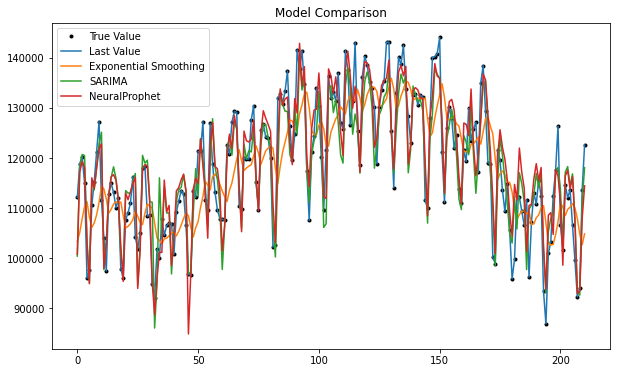

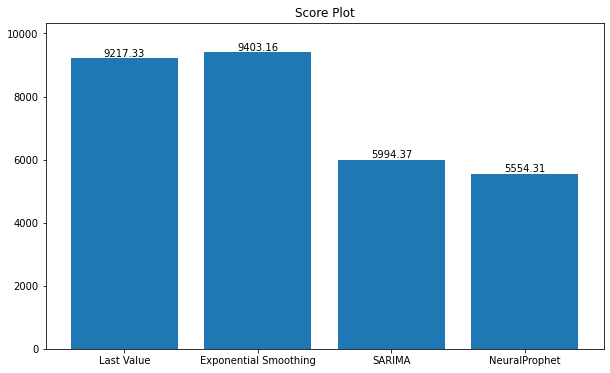

In [24]:
def comparison_plot():
    """Visualizing the training + validation sets"""
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.set_title("Model Comparison")
    ax.plot(df_test["y"].values,'.k', label='True Value')
    ax.plot(last_val_preds, label="Last Value")
    ax.plot(exp_smooth_preds, label="Exponential Smoothing")
    ax.plot(sarima_preds, label="SARIMA")
    ax.plot(neuralprophet_preds, label="NeuralProphet")
    ax.legend()
    plt.show()
    
def score_plot():
    """Visualizing the training + validation sets"""
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    
    scores = {
        "Last Value": last_val_rmse,
        "Exponential Smoothing": exp_smooth_rmse,
        "SARIMA": sarima_rmse,
        "NeuralProphet": neuralprophet_rmse,
    }
    
    ax.set_title("Score Plot")
    ax.bar(scores.keys(), scores.values())
    ax.bar_label(ax.containers[0], label_type='edge')
    ax.margins(y=0.1)
    plt.show()
    
comparison_plot()
score_plot()

### Closing Thoughts

NeuralProphet is a very intuitive framework that is still in the early stages of development. If you want to contribute to this project, you can do so on [Github](https://github.com/ourownstory/neural_prophet). You can also join the NeuralProphet community on [Slack](https://join.slack.com/t/neuralprophet/shared_invite/zt-18de4n6ef-XyJLYUmkL7ULcj77xcJrmQ)!

I did not include exogenous variables in this notebook but think that these would boost model performance. The predictions from the NeuralProphet model could be used as an input feature to an LGBM/XGBoost model. This would likely yield a very forecast.

#### References

1. [Energy for Sustainable Development - MD. Hasanuzzaman, Nasrudin Abd Rahim - 04/03/2017](https://www.sciencedirect.com/book/9780128146453/energy-for-sustainable-development)
2. [Handbook of Statistics - Jean-Marie Dufour, Julien Neves - 01/05/2019](https://www.sciencedirect.com/science/article/abs/pii/S0169716119300367?via%3Dihub)